# Movie Recommender System

In this notebook, I will attempt at implementing a few recommendation algorithms ( popularity based,content based and collaborative filtering) and try to build an ensemble of these models to come up with our  recommendation system.
With us, we have MovieLens datasets.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
import warnings; warnings.simplefilter('ignore')

## Getting  the data and data preprocessing

we have two MovieLens datasets::

The Full Dataset: Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.

The Small Dataset: Comprises of 100,000 ratings applied to 9,000 movies by 943 users.


In [2]:
column_name=['user_id','item_id','rating','timestamp']

In [3]:
df=pd.read_csv('u.data',sep='\t',names=column_name)

In [4]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


 now let's get movie title

In [5]:
column_name=['item_id' ,'movie title','release date' , 'video release date', 'IMDb URL ', 'unknown','Action' ,'Adventure', 'Animation','Children' , 'Comedy' ,'Crime' ,'Documentary' ,'Drama','Fantasy' , 'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi', 'Thriller' , 'War' , 'Western ']

In [6]:
movie_titles=pd.read_csv('u.item',names=column_name,encoding = "ISO-8859-1",sep='|')

In [7]:
movie_titles.head()

,item_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


 we can merge them togather

In [8]:
df=pd.merge(df,movie_titles.drop(columns=['release date' , 'video release date', 'IMDb URL ', 'unknown','Action' ,'Adventure', 'Animation','Children' , 'Comedy' ,'Crime' ,'Documentary' ,'Drama','Fantasy' , 'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi', 'Thriller' , 'War' , 'Western ']))

In [9]:
df.head(1)

,user_id,item_id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)


## EDA

Let's create a ratings dataframe with average rating and number of ratings:

In [10]:
#top rated movies
df.groupby('movie title')['rating'].mean().sort_values(ascending=False).head()

movie title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [11]:
#top movies watched by user
df.groupby('movie title')['rating'].count().sort_values(ascending=False).head()

movie title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [12]:
#  ratings of movie is mean of ratings by all users:
ratings = pd.DataFrame(df.groupby('movie title')['rating'].mean())
ratings.head()

,rating
movie title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [13]:
#movie rating along with numbers of rating by user
ratings['num of ratings'] = pd.DataFrame(df.groupby('movie title')['rating'].count())
ratings.head()

,rating,num of ratings
movie title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


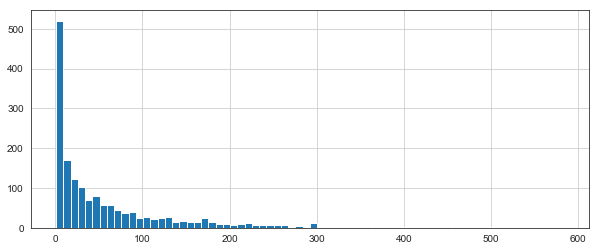

In [14]:
#histagram of number of ratings ie a movie which is rated by how many person
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

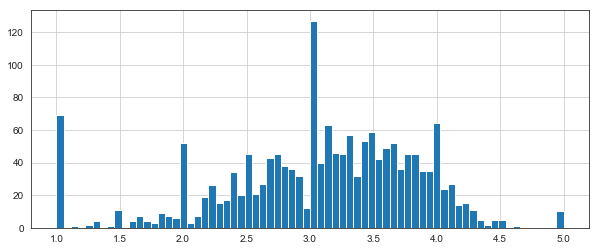

In [15]:
#histagram of ratings given by user
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

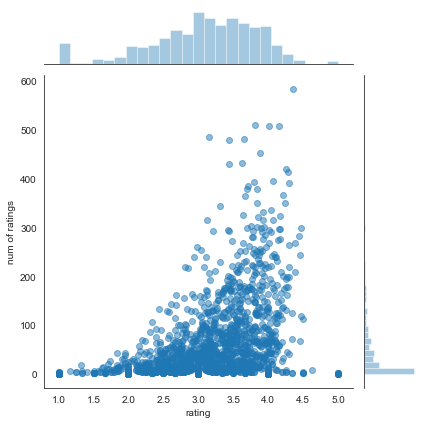

In [16]:
#plot shows both the above histagram 
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

# Simple Recommender


 In this section i will develop basic recommendation systems using pandas , that recommend movie according to popularity

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

The implementation of this model is extremely trivial. All i did is sort our movies based on ratings and popularity and display the top movies of our list .

In [17]:
ratings.head()

,rating,num of ratings
movie title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


In [18]:
ratings.info()
#decoding that there are 1664 rows

<class 'pandas.core.frame.DataFrame'>
Index: 1664 entries, 'Til There Was You (1997) to Á köldum klaka (Cold Fever) (1994)
Data columns (total 2 columns):
rating            1664 non-null float64
num of ratings    1664 non-null int64
dtypes: float64(1), int64(1)
memory usage: 39.0+ KB


In [19]:
ratings['num of ratings'].sum()

100000

In [20]:
temp=ratings [ (ratings['num of ratings']>(100)) & (ratings['rating']>3.5) ]

## Suggestions are:

In [21]:
temp['rating'].sort_values(ascending=False).head(10)

movie title
Close Shave, A (1995)               4.491071
Schindler's List (1993)             4.466443
Wrong Trousers, The (1993)          4.466102
Casablanca (1942)                   4.456790
Shawshank Redemption, The (1994)    4.445230
Rear Window (1954)                  4.387560
Usual Suspects, The (1995)          4.385768
Star Wars (1977)                    4.358491
12 Angry Men (1957)                 4.344000
Citizen Kane (1941)                 4.292929
Name: rating, dtype: float64

# Thank you

# Content Based Recommender

The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste.

For instance, consider a person who loves Dilwale Dulhania Le Jayenge, My Name is Khan and Kabhi Khushi Kabhi Gham. One inference we can obtain is that the person loves the actor Shahrukh Khan and the director Karan Johar. Even if s/he were to access the romance chart, s/he wouldn't find these as the top recommendations.

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as   Content Based Filtering.

### Recommending Similar Movies

I will build two Content Based Recommenders based on  Movie Name

Now let's create a matrix that has the user ids on one access and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [22]:
moviemat = df.pivot_table(index='user_id',columns='movie title',values='rating')
moviemat.head()

movie title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


Most rated movie:

In [23]:
ratings.sort_values('num of ratings',ascending=False).head(5)

,rating,num of ratings
movie title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


In [24]:
suggest=ratings.index
x=12

### for taking input run this code
for i in range(1664):
    print(suggest[i]+"                         "+ str(i))
x=int(input('enter any number'))        

In [25]:
print('you selected '+str(x)+ " "+suggest[x])

you selected 12 8 Seconds (1994)


### change here suggest[x] to full movie name if you want to
ps: movie name must match the dataset

In [26]:
user_ratings = moviemat[suggest[x]]
user_ratings.head()

user_id
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: 8 Seconds (1994), dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [27]:
similar = moviemat.corrwith(user_ratings)

Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [28]:
corr_= pd.DataFrame(similar,columns=['Correlation'])
corr_.dropna(inplace=True)
corr_.head()

,Correlation
movie title,
101 Dalmatians (1996),1.0
2 Days in the Valley (1996),1.0
8 Seconds (1994),1.0
Addams Family Values (1993),-1.0
"African Queen, The (1951)",-1.0


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [29]:
corr_ = corr_.join(ratings['num of ratings'])

## therefore similar movies are::

In [30]:
corr_[corr_['num of ratings']>100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
movie title,,
Young Guns (1988),1.0,101
"Devil's Advocate, The (1997)",1.0,188
Die Hard 2 (1990),1.0,166
Die Hard: With a Vengeance (1995),1.0,151
Seven (Se7en) (1995),1.0,236
Scream (1996),1.0,478
Rumble in the Bronx (1995),1.0,174
"Rock, The (1996)",1.0,378
"River Wild, The (1994)",1.0,146


# Thank you

  . 

# Collaborative Filtering 


Two most common types of recommender systems are **Content-Based** and **Collaborative Filtering (CF)**. 

* Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the "wisdom of the crowd" to recommend items. 
* Content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them.

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers.

Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

actual mathematics behind recommender systems is pretty heavy in Linear Algebra.

Collaborative Filtering
In general, Collaborative filtering (CF) is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective).

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. 

In this section, i will implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity.

In [35]:
import numpy as np 
import pandas as pd

In [37]:
column_name=['userId','movieId','rating','timestamp']
ratings=pd.read_csv('u.data',sep='\t',names=column_name)

In [38]:
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [39]:
user_item = ratings.groupby(['userId', 'movieId'])['rating'].first().unstack(fill_value=0.0)

In [41]:
user_item.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
user_item.shape

(943, 1682)

In [43]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(user_item, k = 50)

In [46]:
U.shape

(943, 50)

In [47]:
Vt.shape

(50, 1682)

In [48]:
sigma_diag_matrix=np.diag(sigma)

In [50]:
#all_user_predicted_ratings_demeaned = all_user_predicted_ratings +  user_ratings_mean.reshape(-1, 1)
all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_item.columns, index=user_item.index)

In [51]:
preds_df.shape

(943, 1682)

In [52]:
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,6.448389,2.950450,1.625981,3.045275,1.647414,1.677801,3.665330,0.230101,1.581494,3.362219,...,0.044845,-0.048244,-0.043236,-0.028824,0.040667,-0.002204,-0.006613,-0.004409,0.007978,0.053666
2,2.334278,0.115586,-0.101178,0.309950,0.149196,0.478109,0.206328,0.125428,1.868183,0.670484,...,0.021613,-0.005844,-0.017532,-0.011688,-0.009124,0.003119,0.009356,0.006237,0.030368,-0.028043
3,0.327603,-0.273722,-0.143939,-0.157102,0.021782,-0.057236,-0.042934,0.501579,-0.041899,0.263806,...,-0.014133,-0.021162,0.057255,0.038170,-0.008297,0.015429,0.046287,0.030858,0.006647,0.002022
4,0.382688,-0.435003,0.044126,0.005795,0.064509,-0.078957,0.300215,-0.034386,-0.117565,-0.121150,...,0.004029,-0.004515,-0.016469,-0.010979,0.010426,0.006779,0.020338,0.013559,-0.001440,-0.025620
5,4.266469,1.925990,0.052194,1.085306,0.669737,0.030129,1.739678,0.829531,0.297069,0.595196,...,0.009230,-0.070531,-0.029523,-0.019682,-0.052096,-0.001925,-0.005775,-0.003850,-0.032994,-0.011765


In [59]:
def get_high_recommended_movies(userId):
    movies_rated_by_user = user_item.loc[userId]
    movies_high_rated_by_user =  movies_rated_by_user[movies_rated_by_user > 3].index
    movies_recommended_for_user = preds_df.loc[userId]
    movies_high_recommend_for_user = movies_recommended_for_user[movies_recommended_for_user > 3].index
    return set(movies_high_recommend_for_user) - set(movies_high_rated_by_user)

In [60]:
get_high_recommended_movies(42)

{70, 97, 111, 168, 265, 393, 432, 443}

In [110]:
get_high_recommended_movies(217)

{174, 385, 405}

# Conclusion
In this notebook, I have built 3 different recommendation engines based on different ideas and algorithms. They are as follows:

## Simple Recommender:
This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.
## Content Based Recommender:
We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.
## Collaborative Filtering:
We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.